Быстро самые тупые гипотезы накинул, не зашло, буду адекватно делать)

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, roc_auc_score

Catbost + датчики

In [2]:
# Загрузка данных
data = pd.read_excel(r'Датчики за июль 2024.xlsx')

# Приведение временных меток к datetime
data['start'] = pd.to_datetime(data['start'])
data['end'] = pd.to_datetime(data['end'])

# Создание целевой переменной
data['target'] = (data['reason'] == 'Аварийная остановка').astype(int)

# Временные признаки
data['duration_diff'] = data['duration'].diff().fillna(0)
data['time_since_last'] = (data['start'] - data['start'].shift(1)).dt.total_seconds().fillna(0)
data['hour'] = data['start'].dt.hour
data['day_of_week'] = data['start'].dt.dayofweek

# Кодирование категориального признака
le = LabelEncoder()
data['reason_encoded'] = le.fit_transform(data['reason'])

# Подготовка признаков и целевой переменной
features = ['duration', 'duration_diff', 'time_since_last', 'hour', 'day_of_week', 'reason_encoded']
X = data[features]
y = data['target']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Обучение модели CatBoost
model = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.1, verbose=100)
model.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC-AUC: {roc_auc_score(y_test, y_proba):.5f}")

0:	learn: 0.4717941	total: 104ms	remaining: 51.8s
100:	learn: 0.0000596	total: 347ms	remaining: 1.37s
200:	learn: 0.0000281	total: 604ms	remaining: 898ms
300:	learn: 0.0000186	total: 850ms	remaining: 562ms
400:	learn: 0.0000144	total: 1.08s	remaining: 267ms
499:	learn: 0.0000133	total: 1.3s	remaining: 0us
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1327
           1       1.00      1.00      1.00         2

    accuracy                           1.00      1329
   macro avg       1.00      1.00      1.00      1329
weighted avg       1.00      1.00      1.00      1329

ROC-AUC: 1.00000


Catbbost + датчики + поломки со сдвигом

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

# Загрузка данных
downtime_july_df = pd.read_excel(r'Простои за июль 2024.xlsx')
sensors_july_df = pd.read_excel(r'Датчики за июль 2024.xlsx')

# Приведение времени к минутам
downtime_july_df['start'] = pd.to_datetime(downtime_july_df['start']).dt.floor('min')
downtime_july_df['end'] = pd.to_datetime(downtime_july_df['end']).dt.floor('min')
sensors_july_df['start'] = pd.to_datetime(sensors_july_df['start']).dt.floor('min')
sensors_july_df['end'] = pd.to_datetime(sensors_july_df['end']).dt.floor('min')

# Создание временного ряда по минутам
full_time_range = pd.date_range(start=downtime_july_df['start'].min(), end=downtime_july_df['end'].max(), freq='T')

# Развертывание данных по времени
downtime_expanded = pd.DataFrame({'timestamp': full_time_range})
sensors_expanded = pd.DataFrame({'timestamp': full_time_range})

downtime_july_df['duration'] = downtime_july_df['duration'].fillna(0)
sensors_july_df['duration'] = sensors_july_df['duration'].fillna(0)

downtime_expanded = downtime_expanded.merge(downtime_july_df, left_on='timestamp', right_on='start', how='left')
sensors_expanded = sensors_expanded.merge(sensors_july_df, left_on='timestamp', right_on='start', how='left')

# Объединение данных
merged_df = pd.merge(downtime_expanded, sensors_expanded, on='timestamp', suffixes=('_x', '_y'))

# Преобразование всех столбцов с типом datetime в числовой формат
for col in merged_df.select_dtypes(include=['datetime64[ns]']).columns:
    merged_df[col] = (merged_df[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Автоматическое определение категориальных признаков
cat_features = merged_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Заполнение пропусков в категориальных признаках
for col in cat_features:
    merged_df[col].fillna('Нет данных', inplace=True)

# Сдвиг целевой переменной на 3 дня вперед (4320 минут)
merged_df['target'] = merged_df['reason_y'].shift(-4320)  # Сдвиг на 3 дня вперед
merged_df['target'] = (merged_df['target'] == 'Аварийная остановка').astype(int)

# Удаление строк с пропусками (последние 4320 строк будут иметь NaN в целевой переменной)
merged_df.dropna(subset=['target'], inplace=True)

# Подготовка данных для обучения
X = merged_df.drop(columns=['reason_y', 'target'])
y = merged_df['target']

# Разделение данных на обучающую и тестовую выборки
# Используем временное разделение: первые 80% данных - train, последние 20% - test
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Обучение модели CatBoost
cat_features_indices = [X.columns.get_loc(col) for col in cat_features if col in X.columns]
model = CatBoostClassifier(cat_features=cat_features_indices, verbose=0)
model.fit(X_train, y_train)

# Предсказание и оценка
y_pred = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC: {roc_auc:.4f}')

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from statsmodels.tsa.arima.model import ARIMA

# Загрузка данных
downtime_july_df = pd.read_excel(r'Простои за июль 2024.xlsx')
sensors_july_df = pd.read_excel(r'Датчики за июль 2024.xlsx')

# Приведение времени к минутам
downtime_july_df['start'] = pd.to_datetime(downtime_july_df['start']).dt.floor('T')
downtime_july_df['end'] = pd.to_datetime(downtime_july_df['end']).dt.floor('T')
sensors_july_df['start'] = pd.to_datetime(sensors_july_df['start']).dt.floor('T')
sensors_july_df['end'] = pd.to_datetime(sensors_july_df['end']).dt.floor('T')

# Создание временного ряда по минутам
full_time_range = pd.date_range(start=downtime_july_df['start'].min(), end=downtime_july_df['end'].max(), freq='T')

# Развертывание данных о простоях по временному ряду
downtime_expanded = pd.DataFrame({'timestamp': full_time_range})
for index, row in downtime_july_df.iterrows():
    downtime_expanded.loc[
        (downtime_expanded['timestamp'] >= row['start']) & 
        (downtime_expanded['timestamp'] <= row['end']), 
        ['downtime', 'reason', 'description', 'component']
    ] = row[['downtime', 'reason', 'description', 'component']]

# Развертывание данных о датчиках по временному ряду
sensors_expanded = pd.DataFrame({'timestamp': full_time_range})
for index, row in sensors_july_df.iterrows():
    sensors_expanded.loc[
        (sensors_expanded['timestamp'] >= row['start']) & 
        (sensors_expanded['timestamp'] <= row['end']), 
        'reason'
    ] = row['reason']

# Объединение данных
merged_df = pd.merge(downtime_expanded, sensors_expanded, on='timestamp', how='left', suffixes=('_downtime', '_sensor'))

# Заполнение пропусков
merged_df['reason_sensor'].fillna('Нет данных', inplace=True)
merged_df.fillna({'downtime': 'Нет данных', 'reason_downtime': 'Нет данных', 'description': 'Нет данных', 'component': 'Нет данных'}, inplace=True)

# Обработка категориальных признаков
cat_features = ['downtime', 'reason_downtime', 'description', 'component', 'reason_sensor']
for col in cat_features:
    merged_df[col] = merged_df[col].astype('category')

# Создание целевой переменной (аварийная остановка)
merged_df['target'] = (merged_df['reason_sensor'] == 'Аварийная остановка').astype(int)

# Сдвиг целевой переменной на 3 дня вперед (4320 минут)
merged_df['target'] = merged_df['target'].shift(-4320)

# Удаление строк с пропусками в целевой переменной
merged_df.dropna(subset=['target'], inplace=True)

# Подготовка данных для обучения
X = merged_df.drop(columns=['target'])
y = merged_df['target']

# Разделение данных на обучающую и тестовую выборки
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Обучение модели CatBoost
cat_features_indices = [X.columns.get_loc(col) for col in cat_features]
model = CatBoostClassifier(cat_features=cat_features_indices, verbose=0)
model.fit(X_train, y_train)

# Предсказание и оценка
y_pred = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC: {roc_auc:.4f}')

C:\Users\Mi\AppData\Local\Temp\ipykernel_19688\2497130037.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  downtime_july_df['start'] = pd.to_datetime(downtime_july_df['start']).dt.floor('T')
C:\Users\Mi\AppData\Local\Temp\ipykernel_19688\2497130037.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  downtime_july_df['end'] = pd.to_datetime(downtime_july_df['end']).dt.floor('T')
C:\Users\Mi\AppData\Local\Temp\ipykernel_19688\2497130037.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sensors_july_df['start'] = pd.to_datetime(sensors_july_df['start']).dt.floor('T')
C:\Users\Mi\AppData\Local\Temp\ipykernel_19688\2497130037.py:16: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sensors_july_df['end'] = pd.to_datetime(sensors_july_df['end']).dt.floor('T')
C:\Users

ROC-AUC: 0.4527


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

# Загрузка данных
downtime_july_df = pd.read_excel(r'Простои за июль 2024.xlsx')
sensors_july_df = pd.read_excel(r'Датчики за июль 2024.xlsx')

# Приведение времени к минутам
downtime_july_df['start'] = pd.to_datetime(downtime_july_df['start']).dt.floor('T')
downtime_july_df['end'] = pd.to_datetime(downtime_july_df['end']).dt.floor('T')
sensors_july_df['start'] = pd.to_datetime(sensors_july_df['start']).dt.floor('T')
sensors_july_df['end'] = pd.to_datetime(sensors_july_df['end']).dt.floor('T')

# Создание временного ряда с интервалом 10 минут
full_time_range = pd.date_range(start=downtime_july_df['start'].min(), end=downtime_july_df['end'].max(), freq='10T')

# Агрегация данных о простоях
downtime_aggregated = pd.DataFrame({'timestamp': full_time_range})
for index, row in downtime_july_df.iterrows():
    mask = (downtime_aggregated['timestamp'] >= row['start']) & (downtime_aggregated['timestamp'] <= row['end'])
    downtime_aggregated.loc[mask, ['downtime', 'reason', 'description', 'component']] = row[['downtime', 'reason', 'description', 'component']]

# Агрегация данных о датчиках
sensors_aggregated = pd.DataFrame({'timestamp': full_time_range})
for index, row in sensors_july_df.iterrows():
    mask = (sensors_aggregated['timestamp'] >= row['start']) & (sensors_aggregated['timestamp'] <= row['end'])
    sensors_aggregated.loc[mask, 'reason'] = row['reason']

# Объединение данных
merged_df = pd.merge(downtime_aggregated, sensors_aggregated, on='timestamp', how='left', suffixes=('_downtime', '_sensor'))

# Заполнение пропусков
merged_df['reason_sensor'].fillna('Нет данных', inplace=True)
merged_df.fillna({'downtime': 'Нет данных', 'reason_downtime': 'Нет данных', 'description': 'Нет данных', 'component': 'Нет данных'}, inplace=True)
# Добавление лаговых признаков
for lag in [1, 2, 3, 6, 12, 24]:  # Лаги за 10, 20, 30, 60, 120 и 240 минут
    merged_df[f'reason_sensor_lag_{lag}'] = merged_df['reason_sensor'].shift(lag)

# Обновление списка категориальных признаков
cat_features = ['downtime', 'reason_downtime', 'description', 'component', 'reason_sensor']
for lag in [1, 2, 3, 6, 12, 24]:
    cat_features.append(f'reason_sensor_lag_{lag}')

# Удаление строк с пропусками после добавления лагов
merged_df.dropna(inplace=True)

# Подготовка данных для обучения
X = merged_df.drop(columns=['target'])
y = merged_df['target']

# Разделение данных на обучающую и тестовую выборки
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Обучение модели CatBoost
cat_features_indices = [X.columns.get_loc(col) for col in cat_features]
model = CatBoostClassifier(cat_features=cat_features_indices, verbose=0)
model.fit(X_train, y_train)

# Предсказание и оценка
y_pred = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred)
print(f'ROC-AUC: {roc_auc:.4f}')

C:\Users\Mi\AppData\Local\Temp\ipykernel_19688\2783687423.py:12: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  downtime_july_df['start'] = pd.to_datetime(downtime_july_df['start']).dt.floor('T')
C:\Users\Mi\AppData\Local\Temp\ipykernel_19688\2783687423.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  downtime_july_df['end'] = pd.to_datetime(downtime_july_df['end']).dt.floor('T')
C:\Users\Mi\AppData\Local\Temp\ipykernel_19688\2783687423.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sensors_july_df['start'] = pd.to_datetime(sensors_july_df['start']).dt.floor('T')
C:\Users\Mi\AppData\Local\Temp\ipykernel_19688\2783687423.py:15: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  sensors_july_df['end'] = pd.to_datetime(sensors_july_df['end']).dt.floor('T')
C:\Users

KeyError: "['target'] not found in axis"

In [7]:
!pip install xgboost
!pip install optuna

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import optuna

# Загрузка данных
downtime_july_df = pd.read_excel(r'Простои за июль 2024.xlsx')
sensors_july_df = pd.read_excel(r'Датчики за июль 2024.xlsx')

# Приведение времени к минутам
downtime_july_df['start'] = pd.to_datetime(downtime_july_df['start']).dt.floor('min')
downtime_july_df['end'] = pd.to_datetime(downtime_july_df['end']).dt.floor('min')
sensors_july_df['start'] = pd.to_datetime(sensors_july_df['start']).dt.floor('min')
sensors_july_df['end'] = pd.to_datetime(sensors_july_df['end']).dt.floor('min')

# Создание временного ряда по часу
full_time_range = pd.date_range(start=downtime_july_df['start'].min(), end=downtime_july_df['end'].max(), freq='H')

# Развертывание данных по времени
downtime_expanded = pd.DataFrame({'timestamp': full_time_range})
sensors_expanded = pd.DataFrame({'timestamp': full_time_range})

# Добавляем duration, оставляя NaN
downtime_july_df['duration'] = downtime_july_df['duration'].fillna(0)
sensors_july_df['duration'] = sensors_july_df['duration'].fillna(0)

# Агрегация только числовых данных по часу
downtime_hourly = downtime_july_df.resample('H', on='start')[['duration']].sum().reset_index()
sensors_hourly = sensors_july_df.resample('H', on='start')[['duration']].sum().reset_index()

# Объединение данных
merged_df = pd.merge(downtime_hourly, sensors_hourly, on='start', suffixes=('_x', '_y'))

# Преобразование всех столбцов с типом datetime в числовой формат
for col in merged_df.select_dtypes(include=['datetime64[ns]']).columns:
    merged_df[col] = (merged_df[col] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# Целевая переменная - наличие аварийного простоя
merged_df['target'] = (merged_df['duration_x'] > 0).astype(int)

# Разделение данных
X = merged_df.drop(columns=['target', 'duration_x'])
y = merged_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Оптимизация гиперпараметров с помощью Optuna
def objective(trial):
    param = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }

    model = xgb.XGBClassifier(**param)
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f'Best trial: {study.best_trial.params}')


ModuleNotFoundError: No module named 'xgboost'

Поломки за 5 лет

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from marked_problems import marked_problems

# Загрузка данных
breakdowns_df = pd.read_excel(r'Поломки за 5 лет.xlsx')

# Создание целевых переменных
breakdowns_df['target'] = breakdowns_df['reason'].map(marked_problems)

# Временные признаки
breakdowns_df['hour'] = breakdowns_df['start'].dt.hour
breakdowns_df['day_of_week'] = breakdowns_df['start'].dt.dayofweek
breakdowns_df['month'] = breakdowns_df['start'].dt.month

# Лаговые признаки
for lag in [1, 3, 7]:
    breakdowns_df[f'breakdowns_last_{lag}_days'] = breakdowns_df['target'].rolling(f'{lag}D').sum()

# Векторизация текста
text_transformer = TfidfVectorizer(max_features=100)
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'reason'),
        ('num', StandardScaler(), ['hour', 'day_of_week', 'month', 'duration'])
    ])

# Разделение данных на обучающую и тестовую выборки
X = breakdowns_df[['reason', 'hour', 'day_of_week', 'month', 'duration']]
y = breakdowns_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

# Предсказание и оценка модели
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'ROC-AUC: {roc_auc}')

ValueError: window must be an integer 0 or greater

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import optuna
from optuna.samplers import TPESampler
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin

from marked_problems import marked_problems

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [22]:
breakdowns_df = pd.read_excel(r'Поломки за 5 лет.xlsx')
breakdowns_df.tail()

,start,end,reason_id,reason_group,reason,duration
526,2024-11-04 16:04:20,2024-11-04 16:07:21,2010004,Breakdowns,Замена тормозной пластины на 10 наполнителе.,3.016667
527,2024-11-04 19:15:34,2024-11-04 19:17:41,2010004,Breakdowns,Замена тормозной пластины на 66 наполнителе,2.100000
528,2024-11-05 09:48:48,2024-11-05 09:51:31,2010004,Breakdowns,замена тормозной пластины,2.716667
529,2024-11-21 03:12:49,2024-11-21 03:16:28,2010004,Breakdowns,МЕХ. Недолив. Пустые банки. 20/32/33/39,3.650000
530,2024-11-21 03:24:45,2024-11-21 03:28:36,2010004,Breakdowns,МЕХ. Недолив. Пустые банки. 20/32/33/39,3.833333


In [24]:
# Создание целевых переменных
breakdowns_df['target'] = breakdowns_df['reason'].map(marked_problems)
breakdowns_df.tail()

,start,end,reason_id,reason_group,reason,duration,target
526,2024-11-04 16:04:20,2024-11-04 16:07:21,2010004,Breakdowns,Замена тормозной пластины на 10 наполнителе.,3.016667,0.0
527,2024-11-04 19:15:34,2024-11-04 19:17:41,2010004,Breakdowns,Замена тормозной пластины на 66 наполнителе,2.100000,0.0
528,2024-11-05 09:48:48,2024-11-05 09:51:31,2010004,Breakdowns,замена тормозной пластины,2.716667,0.0
529,2024-11-21 03:12:49,2024-11-21 03:16:28,2010004,Breakdowns,МЕХ. Недолив. Пустые банки. 20/32/33/39,3.650000,1.0
530,2024-11-21 03:24:45,2024-11-21 03:28:36,2010004,Breakdowns,МЕХ. Недолив. Пустые банки. 20/32/33/39,3.833333,1.0


In [ ]:
# Генерация временных признаков
breakdowns_df['hour'] = breakdowns_df['start'].dt.hour
breakdowns_df['day_of_week'] = breakdowns_df['start'].dt.dayofweek
breakdowns_df['month'] = breakdowns_df['start'].dt.month
breakdowns_df['is_weekend'] = breakdowns_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

,start,end,reason_id,reason_group,reason,duration,target,hour,day_of_week,month,is_weekend
526,2024-11-04 16:04:20,2024-11-04 16:07:21,2010004,Breakdowns,Замена тормозной пластины на 10 наполнителе.,3.016667,0.0,16,0,11,0
527,2024-11-04 19:15:34,2024-11-04 19:17:41,2010004,Breakdowns,Замена тормозной пластины на 66 наполнителе,2.100000,0.0,19,0,11,0
528,2024-11-05 09:48:48,2024-11-05 09:51:31,2010004,Breakdowns,замена тормозной пластины,2.716667,0.0,9,1,11,0
529,2024-11-21 03:12:49,2024-11-21 03:16:28,2010004,Breakdowns,МЕХ. Недолив. Пустые банки. 20/32/33/39,3.650000,1.0,3,3,11,0
530,2024-11-21 03:24:45,2024-11-21 03:28:36,2010004,Breakdowns,МЕХ. Недолив. Пустые банки. 20/32/33/39,3.833333,1.0,3,3,11,0


In [27]:
# Генерация признаков на основе длительности
breakdowns_df['log_duration'] = np.log1p(breakdowns_df['duration'])
breakdowns_df['duration_bin'] = pd.cut(breakdowns_df['duration'], bins=5, labels=False)

In [28]:
breakdowns_df.tail()

,start,end,reason_id,reason_group,reason,duration,target,hour,day_of_week,month,is_weekend,log_duration,duration_bin
526,2024-11-04 16:04:20,2024-11-04 16:07:21,2010004,Breakdowns,Замена тормозной пластины на 10 наполнителе.,3.016667,0.0,16,0,11,0,1.390452,0
527,2024-11-04 19:15:34,2024-11-04 19:17:41,2010004,Breakdowns,Замена тормозной пластины на 66 наполнителе,2.100000,0.0,19,0,11,0,1.131402,0
528,2024-11-05 09:48:48,2024-11-05 09:51:31,2010004,Breakdowns,замена тормозной пластины,2.716667,0.0,9,1,11,0,1.312827,0
529,2024-11-21 03:12:49,2024-11-21 03:16:28,2010004,Breakdowns,МЕХ. Недолив. Пустые банки. 20/32/33/39,3.650000,1.0,3,3,11,0,1.536867,0
530,2024-11-21 03:24:45,2024-11-21 03:28:36,2010004,Breakdowns,МЕХ. Недолив. Пустые банки. 20/32/33/39,3.833333,1.0,3,3,11,0,1.575536,0


In [30]:
# Убедимся, что данные отсортированы по времени
breakdowns_df = breakdowns_df.sort_values(by='start')

# Преобразуем индекс в datetime для работы с временными окнами
breakdowns_df = breakdowns_df.set_index('start')

# Генерация скользящих метрик
for lag in [1, 3, 7]:
    # Количество поломок за последние N дней
    breakdowns_df[f'breakdowns_last_{lag}_days'] = (
        breakdowns_df['target']
        .rolling(f'{lag}D')  # Окно в днях
        .sum()
    )
    
    # Средняя длительность поломок за последние N дней
    breakdowns_df[f'duration_avg_last_{lag}_days'] = (
        breakdowns_df['duration']
        .rolling(f'{lag}D')  # Окно в днях
        .mean()
    )

# Сбросим индекс, чтобы вернуть столбец 'start' обратно
breakdowns_df = breakdowns_df.reset_index()

In [31]:
breakdowns_df.tail()

,start,end,reason_id,reason_group,reason,duration,target,hour,day_of_week,month,is_weekend,log_duration,duration_bin,breakdowns_last_1_days,duration_avg_last_1_days,breakdowns_last_3_days,duration_avg_last_3_days,breakdowns_last_7_days,duration_avg_last_7_days
526,2024-11-04 16:04:20,2024-11-04 16:07:21,2010004,Breakdowns,Замена тормозной пластины на 10 наполнителе.,3.016667,0.0,16,0,11,0,1.390452,0,0.0,3.269444,0.0,3.269444,0.0,3.269444
527,2024-11-04 19:15:34,2024-11-04 19:17:41,2010004,Breakdowns,Замена тормозной пластины на 66 наполнителе,2.100000,0.0,19,0,11,0,1.131402,0,0.0,2.558333,0.0,3.102381,0.0,3.102381
528,2024-11-05 09:48:48,2024-11-05 09:51:31,2010004,Breakdowns,замена тормозной пластины,2.716667,0.0,9,1,11,0,1.312827,0,0.0,2.611111,0.0,3.054167,0.0,3.054167
529,2024-11-21 03:12:49,2024-11-21 03:16:28,2010004,Breakdowns,МЕХ. Недолив. Пустые банки. 20/32/33/39,3.650000,1.0,3,3,11,0,1.536867,0,1.0,3.650000,1.0,3.650000,1.0,3.650000
530,2024-11-21 03:24:45,2024-11-21 03:28:36,2010004,Breakdowns,МЕХ. Недолив. Пустые банки. 20/32/33/39,3.833333,1.0,3,3,11,0,1.575536,0,2.0,3.741667,2.0,3.741667,2.0,3.741667


In [32]:
class TextEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model):
        self.model = model

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return np.array([np.mean([self.model.wv[word] for word in text.split() if word in self.model.wv]
                         or [np.zeros(self.model.vector_size)], axis=0) for text in X])

# Обучение Word2Vec
texts = breakdowns_df['reason'].apply(lambda x: x.split())
w2v_model = Word2Vec(sentences=texts, vector_size=50, window=5, min_count=1, workers=4)

In [33]:
text_transformer = TextEmbedder(w2v_model)
preprocessor = ColumnTransformer(
    transformers=[
        ('text', text_transformer, 'reason'),
        ('num', StandardScaler(), ['hour', 'day_of_week', 'month', 'duration', 'log_duration', 'duration_bin']),
        ('cat', OneHotEncoder(), ['reason_group'])
    ])

In [34]:
X = breakdowns_df[['reason', 'hour', 'day_of_week', 'month', 'duration', 'log_duration', 'duration_bin', 'reason_group']]
y = breakdowns_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [38]:
# Проверка на NaN
print(X_train.isna().sum())
print(y_train.isna().sum())

reason          0
hour            0
day_of_week     0
month           0
duration        0
log_duration    0
duration_bin    0
reason_group    0
dtype: int64
1


In [39]:
# Заполнение пропусков (если они есть)
X_train = X_train.fillna(0)
y_train = y_train.fillna(0)

Optuna light

In [40]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42))
    ])

    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

In [41]:
# Оптимизация гиперпараметров
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)

# Лучшие параметры
print(f'Best ROC-AUC: {study.best_value}')
print(f'Best parameters: {study.best_params}')

[I 2025-02-23 22:03:56,640] A new study created in memory with name: no-name-e73a5f83-09e1-42bf-9b60-7ac037f842f2
[I 2025-02-23 22:03:56,970] Trial 0 finished with value: 0.9588859416445623 and parameters: {'n_estimators': 146, 'max_depth': 23, 'min_samples_split': 2}. Best is trial 0 with value: 0.9588859416445623.
[I 2025-02-23 22:03:57,249] Trial 1 finished with value: 0.946949602122016 and parameters: {'n_estimators': 141, 'max_depth': 47, 'min_samples_split': 9}. Best is trial 0 with value: 0.9588859416445623.
[I 2025-02-23 22:03:57,361] Trial 2 finished with value: 0.9376657824933687 and parameters: {'n_estimators': 51, 'max_depth': 19, 'min_samples_split': 8}. Best is trial 0 with value: 0.9588859416445623.
[I 2025-02-23 22:03:57,505] Trial 3 finished with value: 0.9551282051282051 and parameters: {'n_estimators': 66, 'max_depth': 18, 'min_samples_split': 3}. Best is trial 0 with value: 0.9588859416445623.
[I 2025-02-23 22:03:57,740] Trial 4 finished with value: 0.94297082228116

Best ROC-AUC: 0.9606542882404951
Best parameters: {'n_estimators': 158, 'max_depth': 49, 'min_samples_split': 2}


In [42]:
# Обучение модели с лучшими параметрами
best_params = study.best_params
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**best_params, random_state=42))
])

model.fit(X_train, y_train)
y_pred_proba = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f'Final ROC-AUC: {roc_auc}')

Final ROC-AUC: 0.9606542882404951


In [66]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import optuna
from optuna.samplers import TPESampler
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin

from marked_problems import marked_problems

breakdowns_df = pd.read_excel(r'Поломки за 5 лет.xlsx')
# Создание целевой переменной
breakdowns_df['target'] = breakdowns_df['reason'].map(marked_problems)

# Генерация временных признаков
breakdowns_df['hour'] = breakdowns_df['start'].dt.hour
breakdowns_df['day_of_week'] = breakdowns_df['start'].dt.dayofweek
breakdowns_df['month'] = breakdowns_df['start'].dt.month
breakdowns_df['is_weekend'] = breakdowns_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Генерация признаков на основе длительности
breakdowns_df['log_duration'] = np.log1p(breakdowns_df['duration'])
breakdowns_df['duration_bin'] = pd.cut(breakdowns_df['duration'], bins=5, labels=False)

# Убедимся, что данные отсортированы по времени
breakdowns_df = breakdowns_df.sort_values(by='start')

# Преобразуем индекс в datetime для работы с временными окнами
breakdowns_df = breakdowns_df.set_index('start')

# Генерация скользящих метрик
for lag in [1, 3, 7]:
    breakdowns_df[f'breakdowns_last_{lag}_days'] = breakdowns_df['target'].rolling(f'{lag}D').sum()
    breakdowns_df[f'duration_avg_last_{lag}_days'] = breakdowns_df['duration'].rolling(f'{lag}D').mean()

# Генерация лаговых признаков
for lag in [1, 3, 7]:
    breakdowns_df[f'target_lag_{lag}_days'] = breakdowns_df['target'].shift(lag)
    breakdowns_df[f'duration_lag_{lag}_days'] = breakdowns_df['duration'].shift(lag)

# Сбросим индекс, чтобы вернуть столбец 'start' обратно
breakdowns_df = breakdowns_df.reset_index()

# Препроцессинг данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['hour', 'day_of_week', 'month', 'duration', 'log_duration', 'duration_bin',
                                   'target_lag_1_days', 'target_lag_3_days', 'target_lag_7_days',
                                   'duration_lag_1_days', 'duration_lag_3_days', 'duration_lag_7_days',
                                   'breakdowns_last_1_days', 'breakdowns_last_3_days', 'breakdowns_last_7_days',
                                   'duration_avg_last_1_days', 'duration_avg_last_3_days', 'duration_avg_last_7_days']),
        ('cat', OneHotEncoder(), ['reason_group'])
    ])

# Разделение данных
X = breakdowns_df[['hour', 'day_of_week', 'month', 'duration', 'log_duration', 'duration_bin', 'reason_group',
                   'target_lag_1_days', 'target_lag_3_days', 'target_lag_7_days',
                   'duration_lag_1_days', 'duration_lag_3_days', 'duration_lag_7_days',
                   'breakdowns_last_1_days', 'breakdowns_last_3_days', 'breakdowns_last_7_days',
                   'duration_avg_last_1_days', 'duration_avg_last_3_days', 'duration_avg_last_7_days']]
y = breakdowns_df['target']

# Удаление строк с NaN (если они есть)
X = X.fillna(0)
y = y.fillna(0)

# Функция для Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42))
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

# Оптимизация гиперпараметров
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)

# Лучшие параметры
best_params = study.best_params
print(f'Best ROC-AUC: {study.best_value}')
print(f'Best parameters: {best_params}')

# Обучение модели с лучшими параметрами
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**best_params, random_state=42))
])

model.fit(X, y)

# Убедимся, что данные отсортированы по времени
breakdowns_df = breakdowns_df.sort_values(by='start')

# Преобразуем индекс в datetime для работы с временными окнами
breakdowns_df = breakdowns_df.set_index('start')

# Генерация скользящих метрик
for lag in [1, 3, 7]:
    breakdowns_df[f'breakdowns_last_{lag}_days'] = breakdowns_df['target'].rolling(f'{lag}D').sum()
    breakdowns_df[f'duration_avg_last_{lag}_days'] = breakdowns_df['duration'].rolling(f'{lag}D').mean()

# Генерация лаговых признаков
for lag in [1, 3, 7]:
    breakdowns_df[f'target_lag_{lag}_days'] = breakdowns_df['target'].shift(lag)
    breakdowns_df[f'duration_lag_{lag}_days'] = breakdowns_df['duration'].shift(lag)

# Сбросим индекс, чтобы вернуть столбец 'start' обратно
breakdowns_df = breakdowns_df.reset_index()

# Предсказание на будущие даты
last_date = breakdowns_df['start'].max()
future_dates = [last_date + pd.Timedelta(days=i) for i in [1, 3, 7]]
future_data = pd.DataFrame({'start': future_dates})

# Генерация признаков для будущих дат
future_data['hour'] = future_data['start'].dt.hour
future_data['day_of_week'] = future_data['start'].dt.dayofweek
future_data['month'] = future_data['start'].dt.month
future_data['is_weekend'] = future_data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)
future_data['duration'] = 0
future_data['log_duration'] = np.log1p(future_data['duration'])
future_data['duration_bin'] = pd.cut(future_data['duration'], bins=5, labels=False)

# Добавим скользящие метрики (используем последние доступные данные)
for lag in [1, 3, 7]:
    future_data[f'breakdowns_last_{lag}_days'] = breakdowns_df[f'breakdowns_last_{lag}_days'].iloc[-1]
    future_data[f'duration_avg_last_{lag}_days'] = breakdowns_df[f'duration_avg_last_{lag}_days'].iloc[-1]

# Генерация лаговых признаков для будущих дат
for lag in [1, 3, 7]:
    future_data[f'target_lag_{lag}_days'] = breakdowns_df[f'target_lag_{lag}_days'].iloc[-1]
    future_data[f'duration_lag_{lag}_days'] = breakdowns_df[f'duration_lag_{lag}_days'].iloc[-1]

# Причина (предположим, что неизвестна, используем наиболее частую)
future_data['reason_group'] = breakdowns_df['reason_group'].mode()[0]

# Предсказание
future_predictions = model.predict_proba(future_data)[:, 1]

# Добавляем предсказания в DataFrame
future_data['predicted_probability'] = future_predictions

# Выводим результат
print(future_data[['start', 'predicted_probability']])

[I 2025-02-23 23:16:26,174] A new study created in memory with name: no-name-6f5ee88f-62d7-43a6-9114-bf637b3113d0
[I 2025-02-23 23:16:26,354] Trial 0 finished with value: 0.9825375773651636 and parameters: {'n_estimators': 139, 'max_depth': 26, 'min_samples_split': 2}. Best is trial 0 with value: 0.9825375773651636.
[I 2025-02-23 23:16:26,434] Trial 1 finished with value: 0.980106100795756 and parameters: {'n_estimators': 61, 'max_depth': 38, 'min_samples_split': 4}. Best is trial 0 with value: 0.9825375773651636.
[I 2025-02-23 23:16:26,634] Trial 2 finished with value: 0.9858532272325375 and parameters: {'n_estimators': 178, 'max_depth': 31, 'min_samples_split': 6}. Best is trial 2 with value: 0.9858532272325375.
[I 2025-02-23 23:16:26,708] Trial 3 finished with value: 0.982316534040672 and parameters: {'n_estimators': 59, 'max_depth': 14, 'min_samples_split': 7}. Best is trial 2 with value: 0.9858532272325375.
[I 2025-02-23 23:16:26,877] Trial 4 finished with value: 0.985853227232537

Best ROC-AUC: 0.9871794871794872
Best parameters: {'n_estimators': 100, 'max_depth': 12, 'min_samples_split': 6}
                start  predicted_probability
0 2024-11-22 03:24:45               0.787726
1 2024-11-24 03:24:45               0.787726
2 2024-11-28 03:24:45               0.773262


In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

# Проходим по данным по годам со сдвигом на неделю
yearly_metrics = []

# Получаем уникальные годы
years = breakdowns_df['start'].dt.year.unique()

for year in years[:-1]:
    train_data = breakdowns_df[breakdowns_df['start'].dt.year == year]
    test_data = breakdowns_df[breakdowns_df['start'].dt.year == year + 1]

    if train_data.empty or test_data.empty:
        continue

    X_train = train_data[['hour', 'day_of_week', 'month', 'duration', 'log_duration', 'duration_bin', 'reason_group',
                          'target_lag_1_days', 'target_lag_3_days', 'target_lag_7_days',
                          'duration_lag_1_days', 'duration_lag_3_days', 'duration_lag_7_days',
                          'breakdowns_last_1_days', 'breakdowns_last_3_days', 'breakdowns_last_7_days',
                          'duration_avg_last_1_days', 'duration_avg_last_3_days', 'duration_avg_last_7_days']]
    y_train = train_data['target']

    X_test = test_data[['hour', 'day_of_week', 'month', 'duration', 'log_duration', 'duration_bin', 'reason_group',
                        'target_lag_1_days', 'target_lag_3_days', 'target_lag_7_days',
                        'duration_lag_1_days', 'duration_lag_3_days', 'duration_lag_7_days',
                        'breakdowns_last_1_days', 'breakdowns_last_3_days', 'breakdowns_last_7_days',
                        'duration_avg_last_1_days', 'duration_avg_last_3_days', 'duration_avg_last_7_days']]
    y_test = test_data['target']

    # Обучение модели
    model.fit(X_train.fillna(0), y_train)

    # Предсказание
    y_pred_proba = model.predict_proba(X_test.fillna(0))[:, 1]

    # ROC-AUC метрика
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    yearly_metrics.append({'year': year, 'roc_auc': roc_auc})

    # Строим ROC-кривую
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'Year {year} (ROC-AUC = {roc_auc:.2f})')

# Финальный график ROC-кривых
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Year')
plt.legend()
plt.show()

# График ROC-AUC по годам
metrics_df = pd.DataFrame(yearly_metrics)
plt.plot(metrics_df['year'], metrics_df['roc_auc'], marker='o')
plt.xlabel('Year')
plt.ylabel('ROC-AUC')
plt.title('Yearly ROC-AUC')
plt.show()


ValueError: Input y contains NaN.

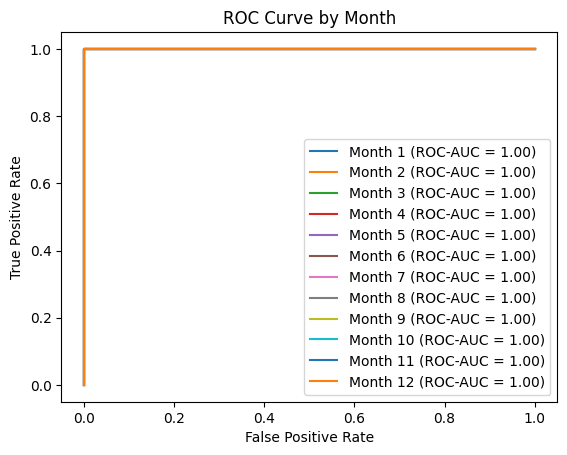

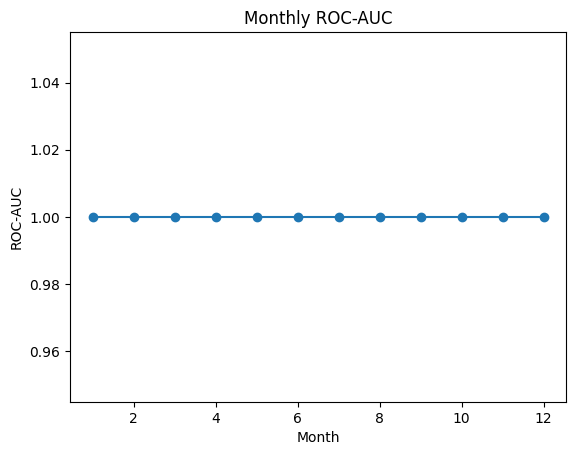

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

# Проходим по данным по месяцам
monthly_metrics = []

for month in range(1, 13):
    monthly_data = breakdowns_df[breakdowns_df['start'].dt.month == month]
    if monthly_data.empty:
        continue

    X_month = monthly_data[['hour', 'day_of_week', 'month', 'duration', 'log_duration', 'duration_bin', 'reason_group',
                            'target_lag_1_days', 'target_lag_3_days', 'target_lag_7_days',
                            'duration_lag_1_days', 'duration_lag_3_days', 'duration_lag_7_days',
                            'breakdowns_last_1_days', 'breakdowns_last_3_days', 'breakdowns_last_7_days',
                            'duration_avg_last_1_days', 'duration_avg_last_3_days', 'duration_avg_last_7_days']]
    y_month = monthly_data['target']

    # Предсказание
    y_pred_proba = model.predict_proba(X_month.fillna(0))[:, 1]
    valid_idx = ~y_month.isna()
    y_month = y_month[valid_idx]
    y_pred_proba = y_pred_proba[valid_idx]
    # ROC-AUC метрика
    roc_auc = roc_auc_score(y_month, y_pred_proba)
    monthly_metrics.append({'month': month, 'roc_auc': roc_auc})

    # Строим ROC-кривую
    fpr, tpr, _ = roc_curve(y_month, y_pred_proba)
    plt.plot(fpr, tpr, label=f'Month {month} (ROC-AUC = {roc_auc:.2f})')

# Финальный график ROC-кривых
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve by Month')
plt.legend()
plt.show()

# График ROC-AUC по месяцам
metrics_df = pd.DataFrame(monthly_metrics)
plt.plot(metrics_df['month'], metrics_df['roc_auc'], marker='o')
plt.xlabel('Month')
plt.ylabel('ROC-AUC')
plt.title('Monthly ROC-AUC')
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import optuna
from optuna.samplers import TPESampler
from gensim.models import Word2Vec
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from marked_problems import marked_problems

# Загрузка данных
breakdowns_df = pd.read_excel(r'Поломки за 5 лет.xlsx')

# Создание целевой переменной
breakdowns_df['target'] = breakdowns_df['reason'].map(marked_problems)

# Генерация временных признаков
breakdowns_df['hour'] = breakdowns_df['start'].dt.hour
breakdowns_df['day_of_week'] = breakdowns_df['start'].dt.dayofweek
breakdowns_df['month'] = breakdowns_df['start'].dt.month
breakdowns_df['is_weekend'] = breakdowns_df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

# Генерация признаков на основе длительности
breakdowns_df['log_duration'] = np.log1p(breakdowns_df['duration'])
breakdowns_df['duration_bin'] = pd.cut(breakdowns_df['duration'], bins=5, labels=False)

# Убедимся, что данные отсортированы по времени
breakdowns_df = breakdowns_df.sort_values(by='start')

# Преобразуем индекс в datetime для работы с временными окнами
breakdowns_df = breakdowns_df.set_index('start')

# Генерация скользящих метрик
for lag in [1, 3, 7]:
    breakdowns_df[f'breakdowns_last_{lag}_days'] = breakdowns_df['target'].rolling(f'{lag}D').sum()
    breakdowns_df[f'duration_avg_last_{lag}_days'] = breakdowns_df['duration'].rolling(f'{lag}D').mean()

# Генерация лаговых признаков
for lag in [1, 3, 7]:
    breakdowns_df[f'target_lag_{lag}_days'] = breakdowns_df['target'].shift(lag)
    breakdowns_df[f'duration_lag_{lag}_days'] = breakdowns_df['duration'].shift(lag)

# Сбросим индекс, чтобы вернуть столбец 'start' обратно
breakdowns_df = breakdowns_df.reset_index()

# Добавляем столбец 'quarter' для агрегации по кварталам
breakdowns_df['quarter'] = breakdowns_df['start'].dt.to_period('Q')

# Препроцессинг данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['hour', 'day_of_week', 'month', 'duration', 'log_duration', 'duration_bin',
                                   'target_lag_1_days', 'target_lag_3_days', 'target_lag_7_days',
                                   'duration_lag_1_days', 'duration_lag_3_days', 'duration_lag_7_days',
                                   'breakdowns_last_1_days', 'breakdowns_last_3_days', 'breakdowns_last_7_days',
                                   'duration_avg_last_1_days', 'duration_avg_last_3_days', 'duration_avg_last_7_days']),
        ('cat', OneHotEncoder(), ['reason_group'])
    ])

# Разделение данных
X = breakdowns_df[['hour', 'day_of_week', 'month', 'duration', 'log_duration', 'duration_bin', 'reason_group',
                   'target_lag_1_days', 'target_lag_3_days', 'target_lag_7_days',
                   'duration_lag_1_days', 'duration_lag_3_days', 'duration_lag_7_days',
                   'breakdowns_last_1_days', 'breakdowns_last_3_days', 'breakdowns_last_7_days',
                   'duration_avg_last_1_days', 'duration_avg_last_3_days', 'duration_avg_last_7_days']]
y = breakdowns_df['target']

# Удаление строк с NaN (если они есть)
X = X.fillna(0)
y = y.fillna(0)

# Функция для Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)

    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, random_state=42))
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return roc_auc_score(y_test, y_pred_proba)

# Оптимизация гиперпараметров
study = optuna.create_study(direction='maximize', sampler=TPESampler())
study.optimize(objective, n_trials=50)

# Лучшие параметры
best_params = study.best_params
print(f'Best ROC-AUC: {study.best_value}')
print(f'Best parameters: {best_params}')
    
# Обучение модели с лучшими параметрами
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(**best_params, random_state=42))
])

# Агрегация данных по кварталам
aggregated_df = breakdowns_df.groupby('quarter').agg({
    'hour': 'mean',
    'day_of_week': 'mean',
    'month': 'mean',
    'duration': 'mean',
    'log_duration': 'mean',
    'duration_bin': lambda x: x.mode()[0],  # Используем моду для категориальных признаков
    'reason_group': lambda x: x.mode()[0],  # Используем моду для категориальных признаков
    'target': 'sum',  # Сумма целевой переменной за квартал
    'breakdowns_last_1_days': 'mean',
    'breakdowns_last_3_days': 'mean',
    'breakdowns_last_7_days': 'mean',
    'duration_avg_last_1_days': 'mean',
    'duration_avg_last_3_days': 'mean',
    'duration_avg_last_7_days': 'mean',
    'target_lag_1_days': 'mean',
    'target_lag_3_days': 'mean',
    'target_lag_7_days': 'mean',
    'duration_lag_1_days': 'mean',
    'duration_lag_3_days': 'mean',
    'duration_lag_7_days': 'mean'
}).reset_index()

# Заполнение пропусков средними значениями для числовых признаков
numeric_columns = aggregated_df.select_dtypes(include=[np.number]).columns
aggregated_df[numeric_columns] = aggregated_df[numeric_columns].fillna(aggregated_df[numeric_columns].mean())

# Заполнение пропусков модой для категориальных признаков
categorical_columns = aggregated_df.select_dtypes(exclude=[np.number]).columns
for col in categorical_columns:
    aggregated_df[col] = aggregated_df[col].fillna(aggregated_df[col].mode()[0])

# Скользящее тестирование с постепенным увеличением данных
results = []  # Список для хранения результатов на каждой итерации
quarters = aggregated_df['quarter'].unique()  # Уникальные кварталы

# Начинаем с первых 2 кварталов
train_end_quarter = 2

for i in range(train_end_quarter, len(quarters)):
    # Обучающая выборка: данные до текущего квартала
    train_data = aggregated_df[aggregated_df['quarter'] < quarters[i]]
    
    # Тестовая выборка: данные на текущий квартал
    test_data = aggregated_df[aggregated_df['quarter'] == quarters[i]]
    
    # Пропускаем итерацию, если обучающая или тестовая выборка пуста
    if train_data.empty or test_data.empty:
        print(f"Пропущена итерация: обучающая или тестовая выборка пуста. Квартал: {quarters[i]}")
        continue
    
    # Обучаем модель на обучающей выборке
    X_train = train_data.drop(columns=['target', 'quarter'])
    y_train = train_data['target']
    
    # Проверяем, что обучающая выборка не пуста
    if len(X_train) == 0:
        print(f"Пропущена итерация: обучающая выборка пуста. Квартал: {quarters[i]}")
        continue
    
    # Проверяем, что в обучающей выборке есть оба класса (0 и 1)
    if len(np.unique(y_train)) < 2:
        print(f"Пропущена итерация: в обучающей выборке только один класс. Квартал: {quarters[i]}")
        continue
    
    # Проверяем, что в y_train нет пропущенных значений
    if y_train.isna().any():
        print(f"Пропущена итерация: в обучающей выборке есть пропущенные значения. Квартал: {quarters[i]}")
        continue
    
    model.fit(X_train, y_train)
    
    # Предсказание на тестовой выборке
    X_test = test_data.drop(columns=['target', 'quarter'])
    y_test = test_data['target']
    
    # Проверяем, что тестовая выборка не пуста
    if len(X_test) == 0:
        print(f"Пропущена итерация: тестовая выборка пуста. Квартал: {quarters[i]}")
        continue
    
    # Проверяем, что в y_test нет пропущенных значений
    if y_test.isna().any():
        print(f"Пропущена итерация: в тестовой выборке есть пропущенные значения. Квартал: {quarters[i]}")
        continue
    
    # Предсказание модели
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Вычисляем метрики
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)  # zero_division для случаев, когда Precision неопределен
    recall = recall_score(y_test, y_pred, zero_division=0)  # zero_division для случаев, когда Recall неопределен
    f1 = f1_score(y_test, y_pred, zero_division=0)  # zero_division для случаев, когда F1 неопределен
    
    # ROC-AUC (только если есть оба класса)
    if len(np.unique(y_test)) >= 2:
        roc_auc = roc_auc_score(y_test, y_pred_proba)
    else:
        roc_auc = None
    
    # Сохраняем результаты
    results.append({
        'quarter': quarters[i],
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    })
    
    # Выводим результаты для текущего квартала
    print(f"Квартал: {quarters[i]}")
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc}")

# Преобразуем результаты в DataFrame для удобства анализа
results_df = pd.DataFrame(results)

# Построим графики для всех метрик
if not results_df.empty:
    plt.figure(figsize=(14, 8))
    
    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(results_df['quarter'], results_df['accuracy'], marker='o', label='Accuracy')
    plt.title('Accuracy по кварталам')
    plt.xlabel('Квартал')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()
    
    # Precision
    plt.subplot(2, 2, 2)
    plt.plot(results_df['quarter'], results_df['precision'], marker='o', label='Precision')
    plt.title('Precision по кварталам')
    plt.xlabel('Квартал')
    plt.ylabel('Precision')
    plt.grid(True)
    plt.legend()
    
    # Recall
    plt.subplot(2, 2, 3)
    plt.plot(results_df['quarter'], results_df['recall'], marker='o', label='Recall')
    plt.title('Recall по кварталам')
    plt.xlabel('Квартал')
    plt.ylabel('Recall')
    plt.grid(True)
    plt.legend()
    
    # F1-Score
    plt.subplot(2, 2, 4)
    plt.plot(results_df['quarter'], results_df['f1'], marker='o', label='F1-Score')
    plt.title('F1-Score по кварталам')
    plt.xlabel('Квартал')
    plt.ylabel('F1-Score')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("Невозможно построить графики: метрики не были вычислены ни для одного квартала.")

[I 2025-02-23 23:11:33,376] A new study created in memory with name: no-name-f2580590-42af-4fe1-b7e4-61c0d5b70f41
[I 2025-02-23 23:11:33,558] Trial 0 finished with value: 0.984526967285588 and parameters: {'n_estimators': 109, 'max_depth': 22, 'min_samples_split': 3}. Best is trial 0 with value: 0.984526967285588.
[I 2025-02-23 23:11:33,687] Trial 1 finished with value: 0.9827586206896551 and parameters: {'n_estimators': 92, 'max_depth': 32, 'min_samples_split': 2}. Best is trial 0 with value: 0.984526967285588.
[I 2025-02-23 23:11:33,807] Trial 2 finished with value: 0.9820954907161804 and parameters: {'n_estimators': 88, 'max_depth': 38, 'min_samples_split': 2}. Best is trial 0 with value: 0.984526967285588.
[I 2025-02-23 23:11:33,908] Trial 3 finished with value: 0.9818744473916888 and parameters: {'n_estimators': 83, 'max_depth': 34, 'min_samples_split': 3}. Best is trial 0 with value: 0.984526967285588.
[I 2025-02-23 23:11:34,112] Trial 4 finished with value: 0.9840848806366048 an

Best ROC-AUC: 0.9871794871794872
Best parameters: {'n_estimators': 119, 'max_depth': 35, 'min_samples_split': 6}


ValueError: pos_label=1 is not a valid label. It should be one of [3.0, 21.0]

In [63]:
# Проверка распределения целевой переменной
print(breakdowns_df['target'].value_counts())

target
0.0    384
1.0    146
Name: count, dtype: int64
